# MILESTONE 2
```
Nama  : Talitha Salsabila
Batch : RMT-032

File ini berisi model prediksi klasifikasi menggunakan Logistic Regression, Random Forest, KNN, Decision Tree, dan XGBooster. Model dibuat menggunakan pipeline dan dilengkapi dengan cross-validation.

```

## Problem statement

PT. Ruangkelas merupakan perusahaan di bidang pendidikan digital. Salah satu program yang ditawarkannya ialah menyediakan kelas online dengan cakupan topik cukup luas, yaitu di bidang kesehatan, seni, sains, programming, dan bisnis. PT. Ruangkelas menyadari bahwa completion rates dari tiap materi / course berhubungan dengan kepuasan user dan berpengaruh kepada retention rates. 

Untuk itu, penting bagi perusahaan untuk memprediksi murid yang memiliki resiko gagal menyelesaikan materi (non-completers). Identifikasi murid yang beresiko besar tidak menyelesaikan materi penting supaya murid dapat mendapatkan bimbingan / support tambahan sejak dini. 

Model prediksi yang diharapkan ialah model yang dapat dengan baik mengidentifikasi true non-completers, dan juga memiliki presisi yang baik supaya bantuan berupa bimbingan tambahan menjadi tepat sasaran.

In [ ]:
def calculate_total_and_status():
    nilai = {}
    nilai["LC1"] = float(input("Masukkan nilai LC1: "))
    nilai["GC1"] = float(input("Masukkan nilai GC1: "))
    nilai["LC2"] = float(input("Masukkan nilai LC2: "))
    nilai["GC2"] = float(input("Masukkan nilai GC2: "))
    nilai["LC3"] = float(input("Masukkan nilai LC3: "))
    nilai["GC3"] = float(input("Masukkan nilai GC3: "))
    nilai["M1"] = float(input("Masukkan nilai M1: "))

    bobot = {
        "Graded Challenges": 0.25,
        "Live Codes": 0.35,
        "Milestone": 0.40
    }

    graded_challenges = (nilai["GC1"] + nilai["GC2"] + nilai["GC3"]) / 3 * bobot["Graded Challenges"]
    live_codes = (nilai["LC1"] + nilai["LC2"] + nilai["LC3"]) / 3 * bobot["Live Codes"]
    milestone = nilai["M1"] * bobot["Milestone"]

    total_nilai = graded_challenges + live_codes + milestone

    def get_status(total_nilai):
        if total_nilai < 70:
            return "Nice try bestie, tetap semangat!!!"
        elif 70 <= total_nilai < 80:
            return "Participant"
        elif 80 <= total_nilai < 90:
            return "Graduate"
        elif 90 <= total_nilai <= 95:
            return "Honors"
        else:
            return "Teacher's Award"

    status = get_status(total_nilai)

    return total_nilai, status

total_nilai, status = calculate_total_and_status()
print("Total Nilai:", total_nilai)
print("Predikat:", status)

## Import libraries

In [3]:
!pip install scikit-learn 1.2.2

ERROR: Could not find a version that satisfies the requirement 1.2.2 (from versions: none)
ERROR: No matching distribution found for 1.2.2


In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve

## Data loading

In [116]:
data = pd.read_csv('online_course_engagement_data.csv')
data

,UserID,CourseCategory,TimeSpentOnCourse,NumberOfVideosWatched,NumberOfQuizzesTaken,QuizScores,CompletionRate,DeviceType,CourseCompletion
0,5618,Health,29.979719,17,3,50.365656,20.860773,1,0
1,4326,Arts,27.802640,1,5,62.615970,65.632415,1,0
2,5849,Arts,86.820485,14,2,78.458962,63.812007,1,1
3,4992,Science,35.038427,17,10,59.198853,95.433162,0,1
4,3866,Programming,92.490647,16,0,98.428285,18.102478,0,0
...,...,...,...,...,...,...,...,...,...
8995,8757,Health,37.445225,14,4,54.469359,32.990704,1,0
8996,894,Science,48.631443,7,7,59.413257,0.254625,0,0
8997,6323,Health,38.212512,3,3,69.508297,70.188159,1,0
8998,3652,Health,70.048665,13,10,79.655182,72.975225,1,1


In [117]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   UserID                 9000 non-null   int64  
 1   CourseCategory         9000 non-null   object 
 2   TimeSpentOnCourse      9000 non-null   float64
 3   NumberOfVideosWatched  9000 non-null   int64  
 4   NumberOfQuizzesTaken   9000 non-null   int64  
 5   QuizScores             9000 non-null   float64
 6   CompletionRate         9000 non-null   float64
 7   DeviceType             9000 non-null   int64  
 8   CourseCompletion       9000 non-null   int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 632.9+ KB


Data terdiri dari 9 kolom dan 9000 rows. Masing-masing kolom memiliki tipe data yang sudah sesuai dengan seharusnya, kecuali kolom DeviceType. Kolom DeviceType lebih cocok bertipe object, karena data berbentuk kategorik.

Features' explanation:

- UserID: Unique identifier for each user

- CourseCategory: Category of the course taken by the user (e.g., Programming, Business, Arts)

- TimeSpentOnCourse: Total time spent by the user on the course in hours

- NumberOfVideosWatched: Total number of videos watched by the user

- NumberOfQuizzesTaken: Total number of quizzes taken by the user

- QuizScores: Average scores achieved by the user in quizzes (percentage)

- CompletionRate: Percentage of course content completed by the user

- DeviceType: Type of device used by the user (Device Type: Desktop (0) or Mobile (1))

- CourseCompletion (Target Variable): Course completion status (0: Not Completed, 1: Completed)

In [118]:
#mengubah tipe data DevicceType

data['DeviceType'] = data['DeviceType'].astype(object)
data['DeviceType'].dtypes

dtype('O')

In [119]:
data.isnull().sum()

UserID                   0
CourseCategory           0
TimeSpentOnCourse        0
NumberOfVideosWatched    0
NumberOfQuizzesTaken     0
QuizScores               0
CompletionRate           0
DeviceType               0
CourseCompletion         0
dtype: int64

Tidak terdapat missing value pada data.

Sebelum lanjut ke EDA, kolom 'UserID' akan dihapus karena tiap row memiliki nilai yang unik, karenanya, tidak akan menjadi pembeda untuk pembuatan cluster.

In [120]:
#drop kolom User_ID

data.drop(['UserID'], axis=1, inplace=True)

In [121]:
# cek duplikasi data

data.duplicated().sum()


877

Terdapat 877 duplikasi data yang selanjutnya akan di drop

In [122]:
# Remove duplicates
data = data.drop_duplicates()

## Exploratory data analysis

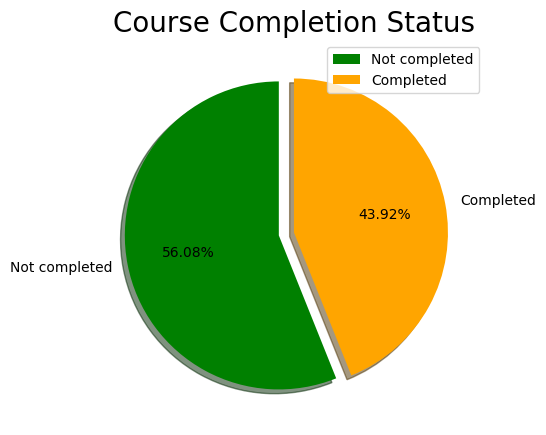

In [123]:
#Melihat presentase gender pada data

labels = ['Not completed', 'Completed']
size = data['CourseCompletion'].value_counts()
colors = ['green', 'orange']
explode = [0.1, 0]

fig, axes = plt.subplots(figsize=(6, 5))
plt.pie(size, colors = colors, explode = explode,
        labels = labels, shadow = True, startangle = 90, autopct = '%.2f%%')
plt.title('Course Completion Status', fontsize = 20)
plt.legend()
plt.show()

Berdasarkan dataset, terdapat lebih banyak orang yang tidak menyelesaikan kursus (56.05%) dibanding yang menyelesaikan kursus (43.92%).

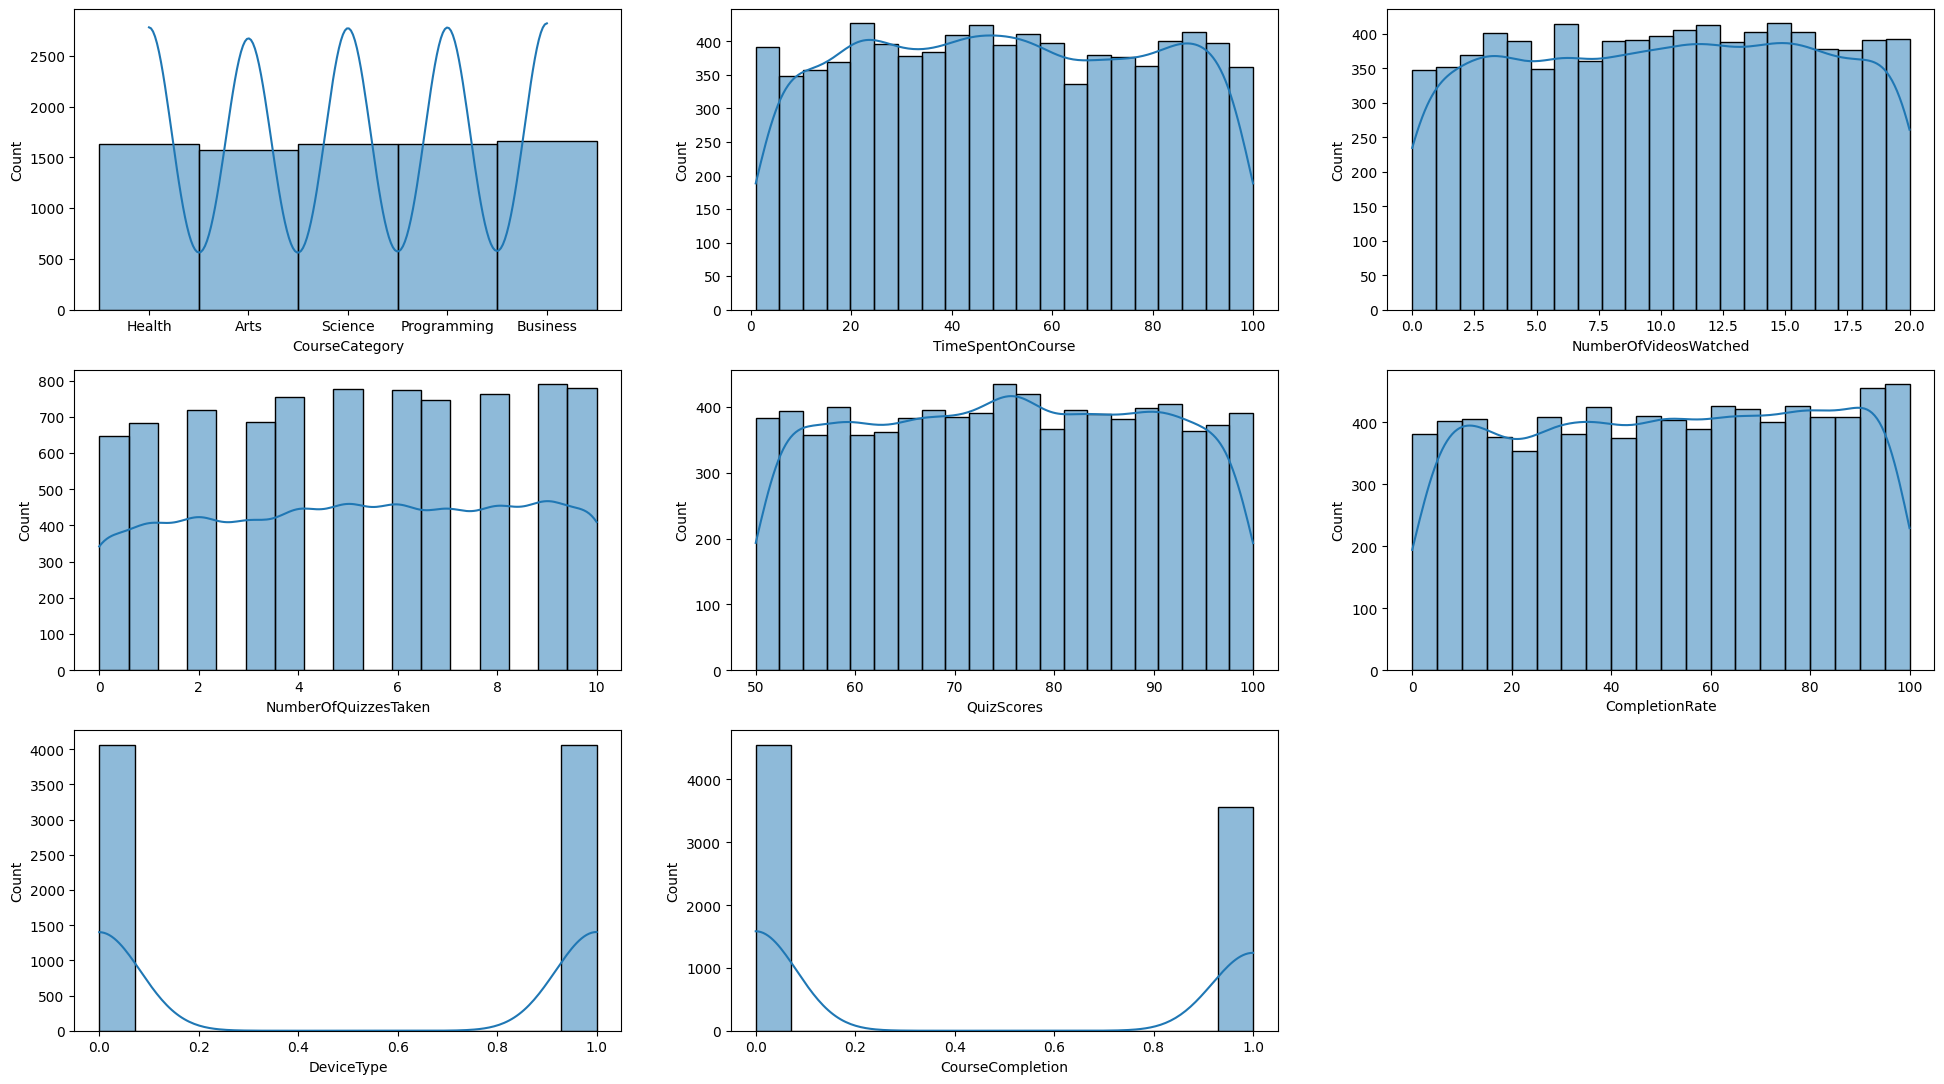

In [124]:
#melihat distribusi data

plt.figure(figsize=(24,32))
for i, col in enumerate(data.columns):
        ax = plt.subplot(7, 3, i+1)
        sns.histplot(data[col], kde=True, ax=ax)
        plt.xlabel(col)
        
plt.show()

Distribusi data tiap feature terlihat normal. Hal yang sama juga teramati pada data kategorik, yaitu course category, dimana jumlah orang pada masing-masing kategori hampir seimbang.

<Axes: >

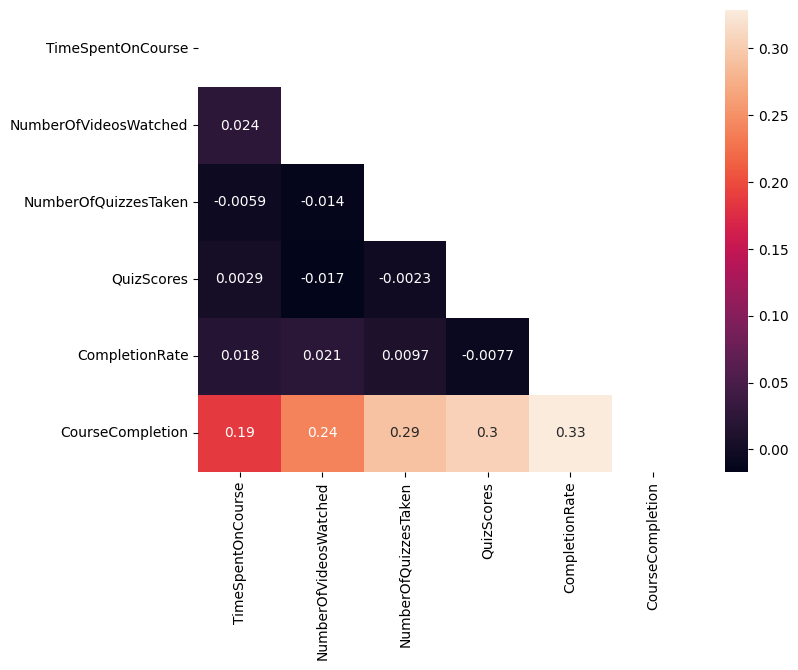

In [125]:
#melihat korelasi antar feature

mask = np.triu(np.ones_like(data.select_dtypes(exclude='object').corr(), dtype=bool))
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(data.select_dtypes(exclude='object').corr(), annot=True, mask=mask)


Korelasi antar features teramati sangat rendah atau hampir tidak berkorelasi. Sedangkan, korelasi antara feature dengan target (Course Completion), terlihat lebih tinggi, walaupun masih tergolong rendah.

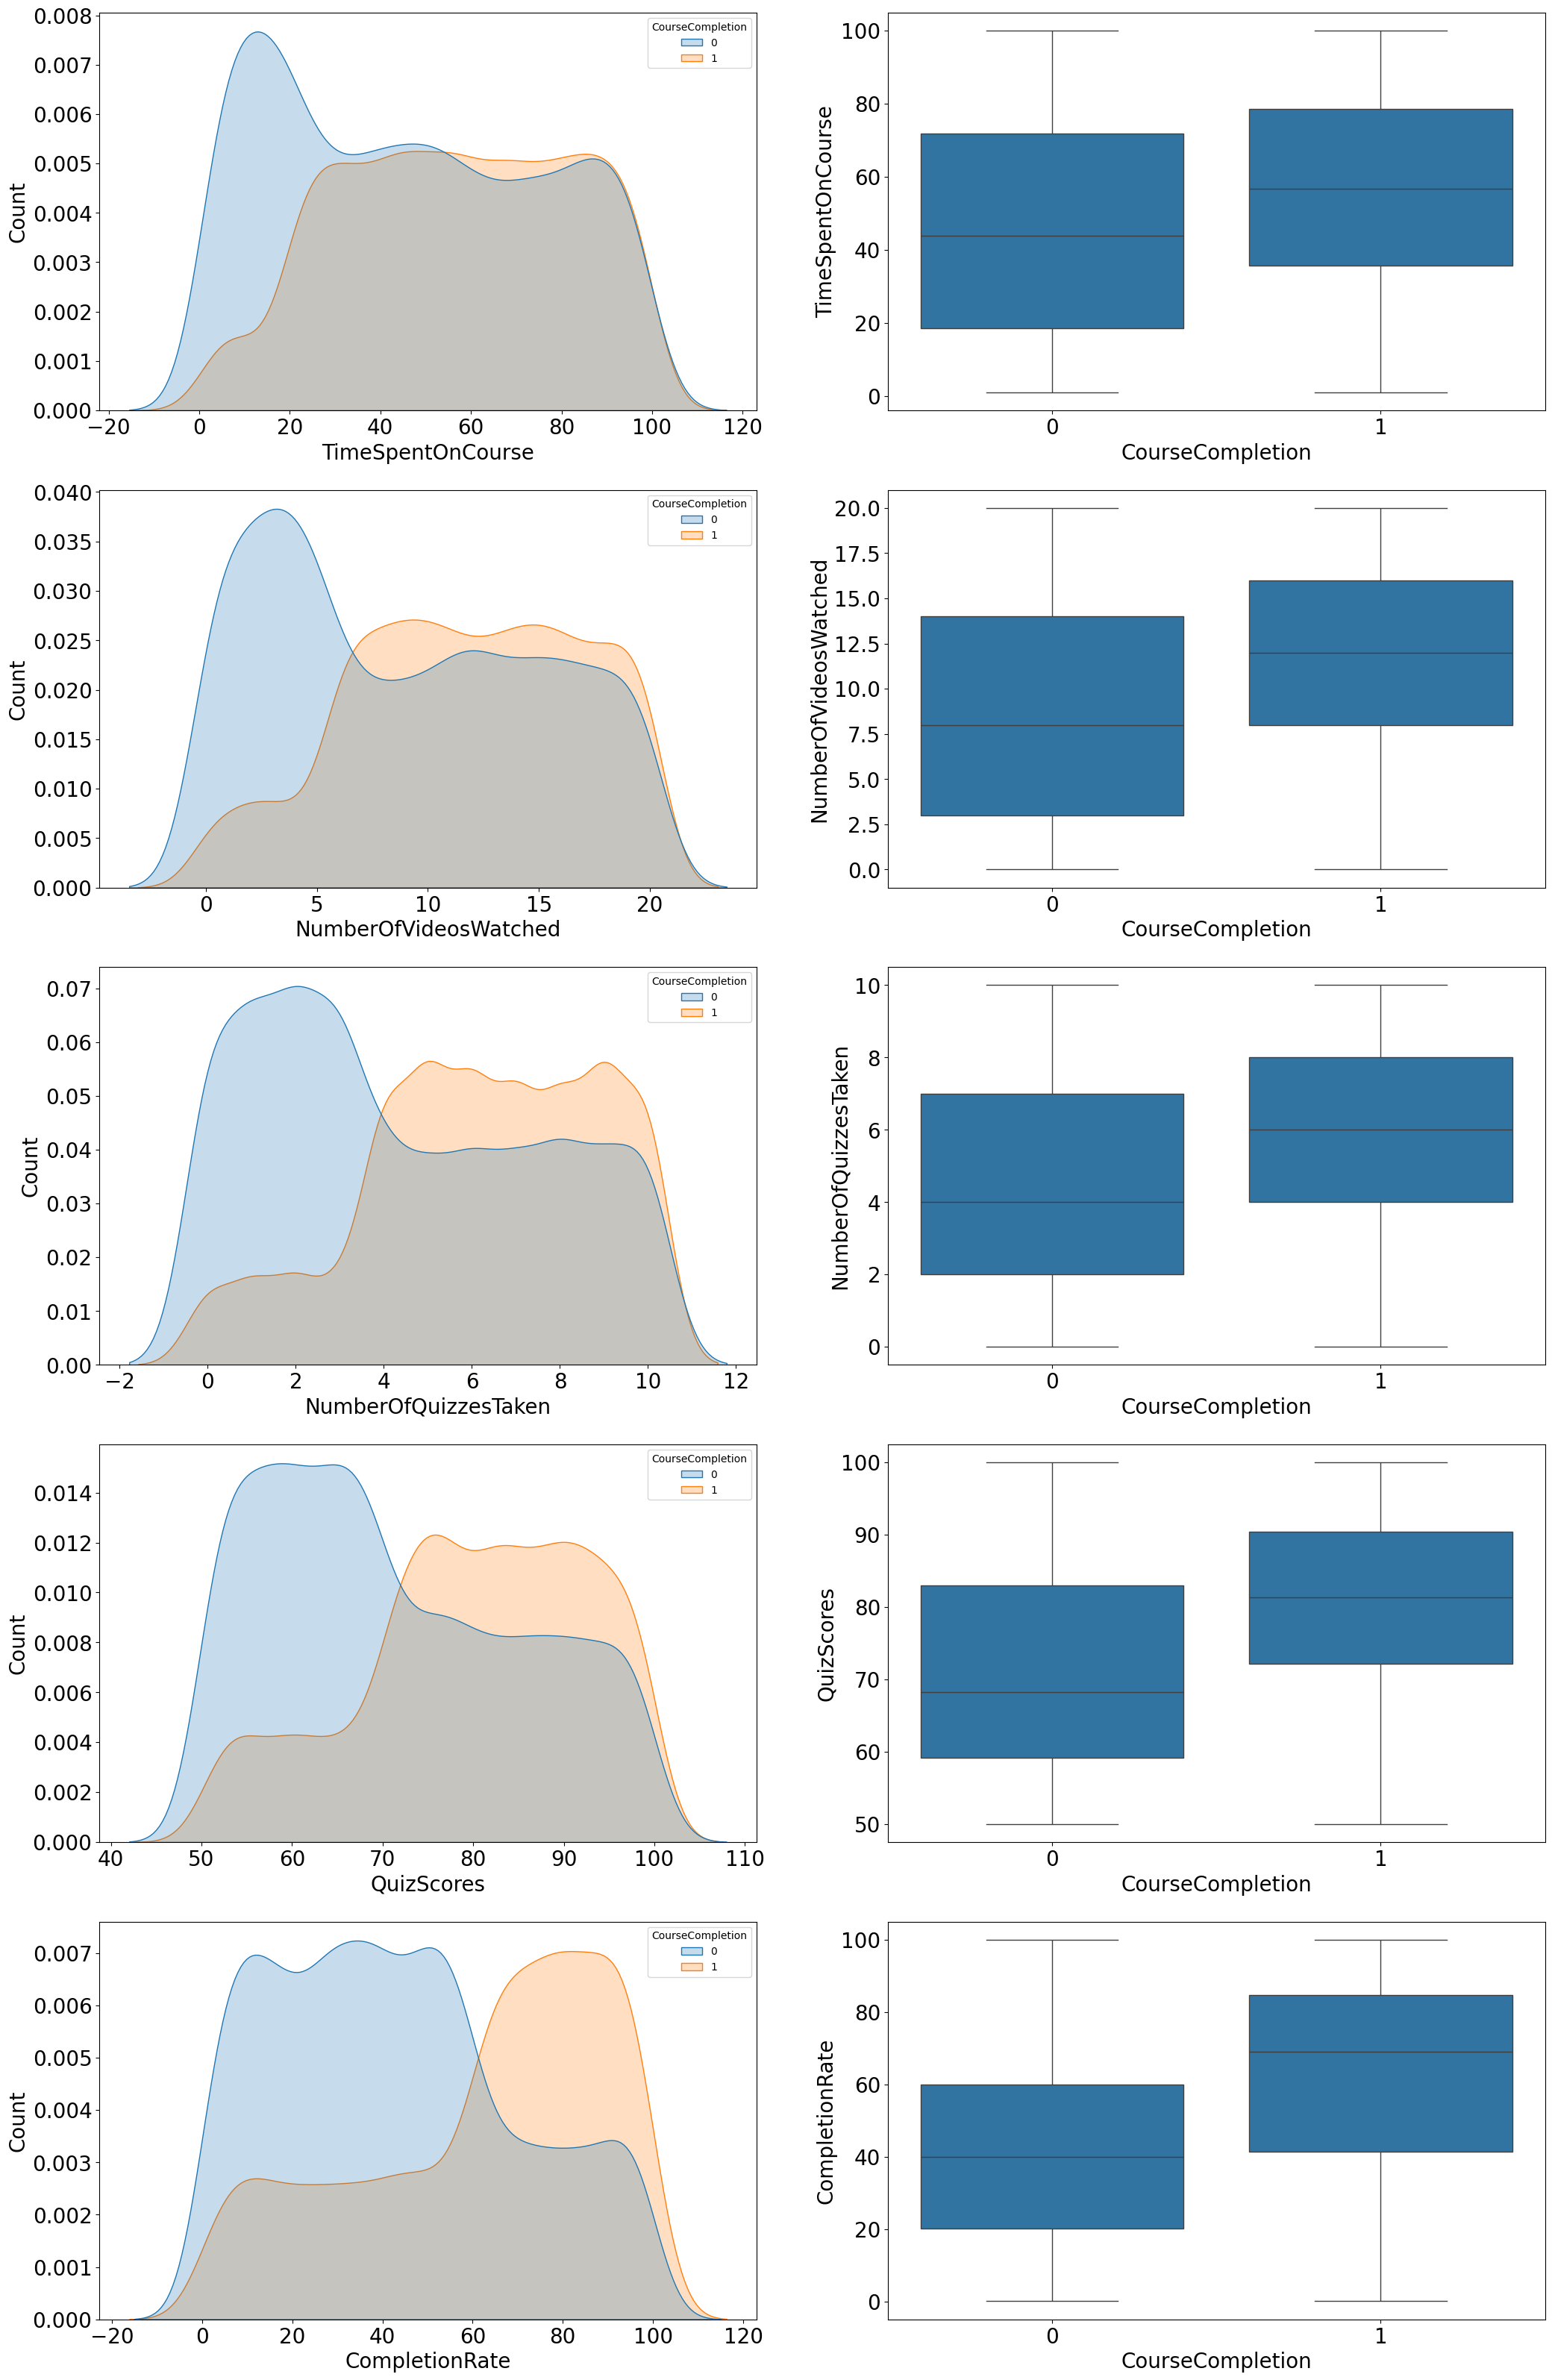

In [126]:
#melihat trends antara complete dan not completed

i = 1
plt.figure(figsize=(25, 90))

features = data[['TimeSpentOnCourse', 'NumberOfVideosWatched', 'NumberOfQuizzesTaken', 'QuizScores', 'CompletionRate']]

for col in features:
    plt.subplot(11, 2, i)
    sns.kdeplot(data=data, hue="CourseCompletion", x=col, fill=True)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel(col, fontsize=20)
    plt.ylabel("Count", fontsize=20)
    i = i + 1
    
    plt.subplot(11, 2, i)
    sns.boxplot(x="CourseCompletion", y=col, data=data)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel("CourseCompletion", fontsize=20)
    plt.ylabel(col, fontsize=20)
    i = i + 1

plt.show()

User dengan status completed dan not completed dapat dibedakan dari rata-rata jumlah untuk tiap featuresnya. User yang menyelesaikan course (completed) mempunyai tendensi memiliki nilai yang tinggi pada kuis (QuizScores), mengerjakan kuis lebih banyak (NumberOfQuizzesTaken), menonton video materi lebih banyak (NumberOfVideosWatched), belajar lebih lama (TimeSpentOnCourse), dan menyelesaikan modul belajar lebih banyak (CompletionRate).

## Feature engineering

In [127]:
#Splitting between 'X' and 'y'

X = data.drop(['CourseCompletion'], axis = 1)
y = data['CourseCompletion']
X

,CourseCategory,TimeSpentOnCourse,NumberOfVideosWatched,NumberOfQuizzesTaken,QuizScores,CompletionRate,DeviceType
0,Health,29.979719,17,3,50.365656,20.860773,1
1,Arts,27.802640,1,5,62.615970,65.632415,1
2,Arts,86.820485,14,2,78.458962,63.812007,1
3,Science,35.038427,17,10,59.198853,95.433162,0
4,Programming,92.490647,16,0,98.428285,18.102478,0
...,...,...,...,...,...,...,...
8995,Health,37.445225,14,4,54.469359,32.990704,1
8996,Science,48.631443,7,7,59.413257,0.254625,0
8997,Health,38.212512,3,3,69.508297,70.188159,1
8998,Health,70.048665,13,10,79.655182,72.975225,1


In [128]:
#Splitting between train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20)
print('Train Size: ', X_train.shape)
print('Test Size: ', X_test.shape)

Train Size:  (6498, 7)
Test Size:  (1625, 7)


### Checking outliers

In [129]:
#melihat persen outlier untuk data train

num_train = X_train._get_numeric_data()
for k, v in num_train.items():
  q1 = v.quantile(0.25)
  q3 = v.quantile(0.75)
  iqr = q3 - q1
  v_col = v[(v <= q1 - 1.5 * iqr) | (v >= q3 + 1.5 * iqr)]
  perc = np.shape(v_col)[0] * 100.0 / np.shape(num_train)[0]
  print("Column %s outliers = %.2f%%" % (k, perc))

Column TimeSpentOnCourse outliers = 0.00%
Column NumberOfVideosWatched outliers = 0.00%
Column NumberOfQuizzesTaken outliers = 0.00%
Column QuizScores outliers = 0.00%
Column CompletionRate outliers = 0.00%


In [130]:
#melihat persen outlier untuk data test

num_test = X_test._get_numeric_data()
for k, v in num_test.items():
  q1 = v.quantile(0.25)
  q3 = v.quantile(0.75)
  iqr = q3 - q1
  v_col = v[(v <= q1 - 1.5 * iqr) | (v >= q3 + 1.5 * iqr)]
  perc = np.shape(v_col)[0] * 100.0 / np.shape(num_test)[0]
  print("Column %s outliers = %.2f%%" % (k, perc))

Column TimeSpentOnCourse outliers = 0.00%
Column NumberOfVideosWatched outliers = 0.00%
Column NumberOfQuizzesTaken outliers = 0.00%
Column QuizScores outliers = 0.00%
Column CompletionRate outliers = 0.00%


Tidak teramati outliers pada data train dan data test

### Checking missing value

In [131]:
X_train.isnull().sum()

CourseCategory           0
TimeSpentOnCourse        0
NumberOfVideosWatched    0
NumberOfQuizzesTaken     0
QuizScores               0
CompletionRate           0
DeviceType               0
dtype: int64

In [132]:
X_test.isnull().sum()

CourseCategory           0
TimeSpentOnCourse        0
NumberOfVideosWatched    0
NumberOfQuizzesTaken     0
QuizScores               0
CompletionRate           0
DeviceType               0
dtype: int64

Tidak terdapat missing value pada data train maupun test

### Split numerical and categorical column

In [133]:
#get numeric and categorical column

num_columns = X_train.select_dtypes(include = np.number).columns.tolist()
cat_columns = X_train.select_dtypes(include = ['object']).columns.tolist()

print('Numeric Columns: ', num_columns)
print('Categorical Columns: ', cat_columns)

Numeric Columns:  ['TimeSpentOnCourse', 'NumberOfVideosWatched', 'NumberOfQuizzesTaken', 'QuizScores', 'CompletionRate']
Categorical Columns:  ['CourseCategory', 'DeviceType']


In [134]:
# Split numerical columns and categorical columns

X_train_num = X_train[num_columns]
X_train_cat = X_train[cat_columns]

X_test_num = X_test[num_columns]
X_test_cat = X_test[cat_columns]

X_train_num

,TimeSpentOnCourse,NumberOfVideosWatched,NumberOfQuizzesTaken,QuizScores,CompletionRate
3464,30.568544,16,10,97.899275,46.304957
8888,81.169064,7,5,74.533208,5.535324
5992,13.200232,2,2,90.294570,10.629067
4586,41.693214,3,2,75.176797,82.508885
8038,66.580567,16,4,62.511516,55.950299
...,...,...,...,...,...
7704,30.310485,16,9,76.176274,11.793145
8092,62.998237,7,6,91.664198,21.374350
4603,23.372690,0,6,83.363508,48.257357
2594,36.129727,12,9,50.621516,15.491894


Scaling data menggunakan standard scaler karena data cukup normal. Sedangkan data kategorik di encoding menggunakan one hot encoder.

In [135]:
#Making column transformer for preprocessing
transformer = ColumnTransformer([
('scaler', StandardScaler(), selector(dtype_exclude='object')),
('encoding', OneHotEncoder(handle_unknown='ignore'), selector(dtype_include='object'))
])

## Modelling

In [136]:
#Making pipeline for SVM
pipe_svm = Pipeline([
('transformer', transformer),
('classifier', SVC())
])

#Making pipeline for KNN
pipe_knn = Pipeline([
('transformer', transformer),
('classifier', KNeighborsClassifier())
])

#Making pipeline for Decision Tree
pipe_dt = Pipeline([
('transformer', transformer),
('classifier', DecisionTreeClassifier())
])

#Making pipeline for Random Forest
pipe_rf = Pipeline([
('transformer', transformer),
('classifier', RandomForestClassifier())
])

#Making pipeline for XGBoost
pipe_xgb = Pipeline([
('transformer', transformer),
('classifier', XGBClassifier())
])

## Base model evaluation

### SVM

In [137]:
pipe_svm.fit(X_train, y_train)
print('Training Score: ',round(pipe_svm.score(X_train, y_train),4))
print('Testing Score: ', round(pipe_svm.score(X_test, y_test),4))

Training Score:  0.891
Testing Score:  0.8886


gap score antara training dan testing kecil, baseline model tergolong cukup good fit

In [138]:
y_svm_pred = pipe_svm.predict(X_test)
y_svm_pred

array([1, 1, 0, ..., 1, 0, 0], dtype=int64)

In [139]:
target = ['Not completed', 'Completed']
print(classification_report(y_test, y_svm_pred, target_names = target))

               precision    recall  f1-score   support

Not completed       0.89      0.92      0.90       930
    Completed       0.89      0.85      0.87       695

     accuracy                           0.89      1625
    macro avg       0.89      0.88      0.89      1625
 weighted avg       0.89      0.89      0.89      1625



In [140]:
#Cross Validation

f1_train_cross_val = cross_val_score(pipe_svm,
                                     X_train,
                                     y_train,
                                     cv=3,
                                     scoring="f1")

print('F1 Score - All - Cross Validation  : ', f1_train_cross_val)
print('F1 Score - Mean - Cross Validation : ', f1_train_cross_val.mean())
print('F1 Score - Std - Cross Validation  : ', f1_train_cross_val.std())
print('F1 Score - Range of Test-Set       : ', (f1_train_cross_val.mean()-f1_train_cross_val.std()) , '-', (f1_train_cross_val.mean()+f1_train_cross_val.std()))

F1 Score - All - Cross Validation  :  [0.83888292 0.84233261 0.86595745]
F1 Score - Mean - Cross Validation :  0.8490576605963759
F1 Score - Std - Cross Validation  :  0.012032654844014523
F1 Score - Range of Test-Set       :  0.8370250057523614 - 0.8610903154403904


### K-Nearest Neighbors

In [141]:
pipe_knn.fit(X_train, y_train)
print('Training Score: ',round(pipe_knn.score(X_train, y_train),4))
print('Testing Score: ', round(pipe_knn.score(X_test, y_test),4))

Training Score:  0.8909
Testing Score:  0.8554


Score training lebih besar dari testing, baseline model dapat tergolong overfit

In [142]:
y_knn_pred = pipe_knn.predict(X_test)
y_knn_pred

array([1, 1, 0, ..., 1, 0, 0], dtype=int64)

In [143]:
target = ['Not completed', 'Completed']
print(classification_report(y_test, y_knn_pred, target_names = target))

               precision    recall  f1-score   support

Not completed       0.88      0.87      0.87       930
    Completed       0.82      0.84      0.83       695

     accuracy                           0.86      1625
    macro avg       0.85      0.85      0.85      1625
 weighted avg       0.86      0.86      0.86      1625



In [144]:
#Cross Validation

f1_train_cross_val = cross_val_score(pipe_knn,
                                     X_train,
                                     y_train,
                                     cv=3,
                                     scoring="f1")

print('F1 Score - All - Cross Validation  : ', f1_train_cross_val)
print('F1 Score - Mean - Cross Validation : ', f1_train_cross_val.mean())
print('F1 Score - Std - Cross Validation  : ', f1_train_cross_val.std())
print('F1 Score - Range of Test-Set       : ', (f1_train_cross_val.mean()-f1_train_cross_val.std()) , '-', (f1_train_cross_val.mean()+f1_train_cross_val.std()))

F1 Score - All - Cross Validation  :  [0.80314136 0.81002088 0.81532004]
F1 Score - Mean - Cross Validation :  0.8094940933519948
F1 Score - Std - Cross Validation  :  0.004985859445709563
F1 Score - Range of Test-Set       :  0.8045082339062852 - 0.8144799527977045


### Decision tree

In [145]:
pipe_dt.fit(X_train, y_train)
print('Training Score: ',round(pipe_dt.score(X_train, y_train),4))
print('Testing Score: ', round(pipe_dt.score(X_test, y_test),4))

Training Score:  1.0
Testing Score:  0.92


Hasil test cukup bagus, namun model tergolong overfit dengan nilai train yang sangat sempurna.

In [146]:
y_dt_pred = pipe_dt.predict(X_test)
y_dt_pred

array([1, 1, 0, ..., 1, 0, 0], dtype=int64)

In [147]:
target = ['Not completed', 'Completed']
print(classification_report(y_test, y_dt_pred, target_names = target))

               precision    recall  f1-score   support

Not completed       0.93      0.93      0.93       930
    Completed       0.91      0.90      0.91       695

     accuracy                           0.92      1625
    macro avg       0.92      0.92      0.92      1625
 weighted avg       0.92      0.92      0.92      1625



In [148]:
#Cross Validation

f1_train_cross_val = cross_val_score(pipe_dt,
                                     X_train,
                                     y_train,
                                     cv=3,
                                     scoring="f1")

print('F1 Score - All - Cross Validation  : ', f1_train_cross_val)
print('F1 Score - Mean - Cross Validation : ', f1_train_cross_val.mean())
print('F1 Score - Std - Cross Validation  : ', f1_train_cross_val.std())
print('F1 Score - Range of Test-Set       : ', (f1_train_cross_val.mean()-f1_train_cross_val.std()) , '-', (f1_train_cross_val.mean()+f1_train_cross_val.std()))

F1 Score - All - Cross Validation  :  [0.89198966 0.89087093 0.88192268]
F1 Score - Mean - Cross Validation :  0.8882610910005934
F1 Score - Std - Cross Validation  :  0.00450514721242341
F1 Score - Range of Test-Set       :  0.8837559437881699 - 0.8927662382130168


### Random forest

In [149]:
pipe_rf.fit(X_train, y_train)
print('Training Score: ',round(pipe_rf.score(X_train, y_train),4))
print('Testing Score: ', round(pipe_rf.score(X_test, y_test),4))

Training Score:  0.9998
Testing Score:  0.9655


Seperti model decision tree, baseline model random forest tergolong overfit. Namun, gap pada model random forest lebih rendah daripada model decision tree.

In [150]:
y_rf_pred = pipe_rf.predict(X_test)
y_rf_pred

array([1, 1, 0, ..., 1, 0, 0], dtype=int64)

In [151]:
target = ['Not completed', 'Completed']
print(classification_report(y_test, y_rf_pred, target_names = target))

               precision    recall  f1-score   support

Not completed       0.96      0.98      0.97       930
    Completed       0.98      0.94      0.96       695

     accuracy                           0.97      1625
    macro avg       0.97      0.96      0.96      1625
 weighted avg       0.97      0.97      0.97      1625



In [152]:
#Cross Validation

f1_train_cross_val = cross_val_score(pipe_rf,
                                     X_train,
                                     y_train,
                                     cv=3,
                                     scoring="f1")

print('F1 Score - All - Cross Validation  : ', f1_train_cross_val)
print('F1 Score - Mean - Cross Validation : ', f1_train_cross_val.mean())
print('F1 Score - Std - Cross Validation  : ', f1_train_cross_val.std())
print('F1 Score - Range of Test-Set       : ', (f1_train_cross_val.mean()-f1_train_cross_val.std()) , '-', (f1_train_cross_val.mean()+f1_train_cross_val.std()))

F1 Score - All - Cross Validation  :  [0.94211365 0.94981511 0.9522293 ]
F1 Score - Mean - Cross Validation :  0.9480526853633741
F1 Score - Std - Cross Validation  :  0.004313637241119335
F1 Score - Range of Test-Set       :  0.9437390481222547 - 0.9523663226044934


### XGBoost

In [153]:
pipe_xgb.fit(X_train, y_train)
print('Training Score: ',round(pipe_xgb.score(X_train, y_train),4))
print('Testing Score: ', round(pipe_xgb.score(X_test, y_test),4))

Training Score:  0.9935
Testing Score:  0.9557


Dengan hasil testing score 95%, model XGBoost tergolong baik namun model overfit dan harus diimprove supaya gap antara training dan testing score mengecil.

In [154]:
y_xgb_pred = pipe_xgb.predict(X_test)
y_xgb_pred

array([1, 1, 0, ..., 1, 0, 0])

In [155]:
target = ['Not completed', 'Completed']
print(classification_report(y_test, y_xgb_pred, target_names = target))

               precision    recall  f1-score   support

Not completed       0.95      0.97      0.96       930
    Completed       0.96      0.93      0.95       695

     accuracy                           0.96      1625
    macro avg       0.96      0.95      0.95      1625
 weighted avg       0.96      0.96      0.96      1625



In [156]:
#Cross Validation

f1_train_cross_val = cross_val_score(pipe_xgb,
                                     X_train,
                                     y_train,
                                     cv=3,
                                     scoring="f1")

print('F1 Score - All - Cross Validation  : ', f1_train_cross_val)
print('F1 Score - Mean - Cross Validation : ', f1_train_cross_val.mean())
print('F1 Score - Std - Cross Validation  : ', f1_train_cross_val.std())
print('F1 Score - Range of Test-Set       : ', (f1_train_cross_val.mean()-f1_train_cross_val.std()) , '-', (f1_train_cross_val.mean()+f1_train_cross_val.std()))

F1 Score - All - Cross Validation  :  [0.93551797 0.94415174 0.94379639]
F1 Score - Mean - Cross Validation :  0.9411553678532206
F1 Score - Std - Cross Validation  :  0.003988880786437864
F1 Score - Range of Test-Set       :  0.9371664870667827 - 0.9451442486396585


## Base model comparison

In [157]:
models = {
    'SVM' : pipe_svm,
    'Decision Tree' : pipe_dt,
    'Random Forest' : pipe_rf,
    'XGBoost' : pipe_xgb,
    'KNN' : pipe_knn
 }

metrics = {
    'Accuracy' : accuracy_score,
    'F1-Score' : f1_score,
    'Recall' : recall_score,
    'Precision' : precision_score
}

df_model = pd.DataFrame(columns = models.keys(), index=['Accuracy', 'F1-Score', 'Recall', 'Precision'])

for metric in metrics.keys():
  for model in models.keys():
    df_model.loc[metric, model] = metrics[metric](y_test, models[model].predict(X_test))

In [158]:
df_model

,SVM,Decision Tree,Random Forest,XGBoost,KNN
Accuracy,0.888615,0.92,0.965538,0.955692,0.855385
F1-Score,0.866618,0.906205,0.959004,0.947445,0.832502
Recall,0.846043,0.903597,0.942446,0.933813,0.840288
Precision,0.888218,0.908828,0.976155,0.961481,0.824859


Baseline model yang memiliki nilai f1-score terbaik ialah model random forest. Secara keseluruhan, semua baseline model overfitting. Sedangkan, cross-validation score secara keseluruhan memiliki rata-rata di bawah testing score. Dibanding dengan training score, cross validation score lebih baik dalam memprediksi testing score karena gap nilainya tidak jauh.

## Hyperparameter tuning

### Random forest

In [159]:
# parameter tuning

from sklearn.model_selection import RandomizedSearchCV

param_rf = {
    'classifier__n_estimators' : [200, 100],
    'classifier__max_depth' : [4,8,2]
}

random_rf = RandomizedSearchCV(pipe_rf, param_rf, cv=5)
random_rf.fit(X_train, y_train)


c:\Users\Zenbook 14x\miniconda3\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(transformers=[('scaler',
                                                                               StandardScaler(),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x000001A3275C2F60>),
                                                                              ('encoding',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x000001A323BBEB70>)])),
                                             ('classifier',
                                              RandomForestClassifier())]),
                   param_distributions={'classifier__max_depth': [4, 8, 2],
                                        'classifier__n_estimators': [200, 100]})

In [160]:
# Get Best Hyperparameters

best_params = random_rf.best_params_
best_params

{'classifier__n_estimators': 100, 'classifier__max_depth': 8}

In [161]:
# Get Best Estimator

best_estimator_rf = random_rf.best_estimator_
best_estimator_rf

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001A3276CDF70>),
                                                 ('encoding',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001A3231A02C0>)])),
                ('classifier', RandomForestClassifier(max_depth=8))])

In [162]:
print('Classification report for train set: ')
print(classification_report(y_train, best_estimator_rf.predict(X_train)))
print('\n')
print('Classification report for test set: ')
print(classification_report(y_test, best_estimator_rf.predict(X_test)))

Classification report for train set: 
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      3625
           1       0.97      0.94      0.95      2873

    accuracy                           0.96      6498
   macro avg       0.96      0.96      0.96      6498
weighted avg       0.96      0.96      0.96      6498



Classification report for test set: 
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       930
           1       0.98      0.94      0.96       695

    accuracy                           0.97      1625
   macro avg       0.97      0.96      0.96      1625
weighted avg       0.97      0.97      0.97      1625



model cukup good fit, score pada train set dan test set sama.

### XGBoost

In [163]:
# parameter tuning

param_xgb = {
    'classifier__n_estimators' : [200, 100],
    'classifier__max_depth' : [4,8,2]
}

random_xgb = RandomizedSearchCV(pipe_xgb, param_xgb, cv=5)
random_xgb.fit(X_train, y_train)

c:\Users\Zenbook 14x\miniconda3\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(transformers=[('scaler',
                                                                               StandardScaler(),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x000001A3275C2F60>),
                                                                              ('encoding',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x000001A323BBEB70>)])),...
                                                            max_bin=None,
                                                            max_cat_threshold=None,
                                                            max_cat_to_onehot=None,
                                                            max_delta_step=None,
                                                            max_depth=None,
                                                            max_leaves=None,
                                                            min_child_weight=None,
                                                            missing=nan,
                                                            monotone_constraints=None,
                                                            multi_strategy=None,
                                                            n_estimators=None,
                                                            n_jobs=None,
                                                            num_parallel_tree=None,
                                                            random_state=None, ...))]),
                   param_distributions={'classifier__max_depth': [4, 8, 2],
                                        'classifier__n_estimators': [200, 100]})

In [164]:
# Get Best Estimator

best_estimator_xgb = random_xgb.best_estimator_
best_estimator_xgb

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001A326FDB560>),
                                                 ('encoding',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001A3270AD4C0>)])),
                ('classifier',
                 XGBClassifier(base_s...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=2, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [165]:
print('Classification report for train set: ')
print(classification_report(y_train, best_estimator_xgb.predict(X_train)))
print('\n')
print('Classification report for test set: ')
print(classification_report(y_test, best_estimator_xgb.predict(X_test)))

Classification report for train set: 
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      3625
           1       0.96      0.93      0.95      2873

    accuracy                           0.96      6498
   macro avg       0.96      0.95      0.95      6498
weighted avg       0.96      0.96      0.96      6498



Classification report for test set: 
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       930
           1       0.97      0.94      0.96       695

    accuracy                           0.96      1625
   macro avg       0.96      0.96      0.96      1625
weighted avg       0.96      0.96      0.96      1625



model cukup good fit, score pada train set dan test set tidak berbeda jauh.

### SVM

In [166]:
# parameter tuning

param_svm = {
    'classifier__C' : [0.01, 1, 30],
    'classifier__kernel' : ['rbf', 'poly']
}

random_svm = RandomizedSearchCV(pipe_svm, param_svm,cv=5)
random_svm.fit(X_train, y_train)


c:\Users\Zenbook 14x\miniconda3\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(transformers=[('scaler',
                                                                               StandardScaler(),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x000001A3275C2F60>),
                                                                              ('encoding',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x000001A323BBEB70>)])),
                                             ('classifier', SVC())]),
                   param_distributions={'classifier__C': [0.01, 1, 30],
                                        'classifier__kernel': ['rbf', 'poly']})

In [168]:
# Get Best Estimator

best_estimator_svm = random_svm.best_estimator_
best_estimator_svm

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001A3276CE480>),
                                                 ('encoding',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001A3276CEA20>)])),
                ('classifier', SVC(C=30))])

In [169]:
print('Classification report for train set: ')
print(classification_report(y_train, best_estimator_svm.predict(X_train)))
print('\n')
print('Classification report for test set: ')
print(classification_report(y_test, best_estimator_svm.predict(X_test)))

Classification report for train set: 
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      3625
           1       0.93      0.91      0.92      2873

    accuracy                           0.93      6498
   macro avg       0.93      0.93      0.93      6498
weighted avg       0.93      0.93      0.93      6498



Classification report for test set: 
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       930
           1       0.90      0.88      0.89       695

    accuracy                           0.91      1625
   macro avg       0.91      0.90      0.90      1625
weighted avg       0.91      0.91      0.91      1625



Model overfit, nilai pada test set lebih rendah daripada train set.

### KNN

In [170]:
# parameter tuning

param_knn = {
    'classifier__n_neighbors' : [5, 20, 30],
}

random_knn = RandomizedSearchCV(pipe_knn, param_knn, cv=5)
random_knn.fit(X_train, y_train)

c:\Users\Zenbook 14x\miniconda3\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(transformers=[('scaler',
                                                                               StandardScaler(),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x000001A3275C2F60>),
                                                                              ('encoding',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x000001A323BBEB70>)])),
                                             ('classifier',
                                              KNeighborsClassifier())]),
                   param_distributions={'classifier__n_neighbors': [5, 20, 30]})

In [171]:
# Get Best Estimator

best_estimator_knn = random_knn.best_estimator_
best_estimator_knn

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001A326FDB5F0>),
                                                 ('encoding',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001A327931A90>)])),
                ('classifier', KNeighborsClassifier(n_neighbors=30))])

In [172]:
print('Classification report for train set: ')
print(classification_report(y_train, best_estimator_knn.predict(X_train)))
print('\n')
print('Classification report for test set: ')
print(classification_report(y_test, best_estimator_knn.predict(X_test)))

Classification report for train set: 
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      3625
           1       0.86      0.83      0.85      2873

    accuracy                           0.87      6498
   macro avg       0.87      0.86      0.86      6498
weighted avg       0.87      0.87      0.87      6498



Classification report for test set: 
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       930
           1       0.86      0.84      0.85       695

    accuracy                           0.87      1625
   macro avg       0.87      0.87      0.87      1625
weighted avg       0.87      0.87      0.87      1625



Dibanding dengan model lain, model KNN tergolong underfit karena memiliki score yang relatif rendah.

### Decision tree

In [173]:
# parameter tuning

param_dt = {
    'classifier__min_samples_split' : [2, 10, 15],
    'classifier__max_depth' : ['None', 10]
}

random_dt = RandomizedSearchCV(pipe_dt, param_dt,cv=5)
random_dt.fit(X_train, y_train)

c:\Users\Zenbook 14x\miniconda3\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\Zenbook 14x\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Zenbook 14x\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Zenbook 14x\miniconda3\Lib\site-pac

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(transformers=[('scaler',
                                                                               StandardScaler(),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x000001A3275C2F60>),
                                                                              ('encoding',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x000001A323BBEB70>)])),
                                             ('classifier',
                                              DecisionTreeClassifier())]),
                   param_distributions={'classifier__max_depth': ['None', 10],
                                        'classifier__min_samples_split': [2, 10,
                                                                          15]})

In [174]:
# Get Best Estimator

best_estimator_dt = random_dt.best_estimator_
best_estimator_dt

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001A326E327E0>),
                                                 ('encoding',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001A3270DA3F0>)])),
                ('classifier',
                 DecisionTreeClassifier(max_depth=10, min_samples_split=15))])

In [175]:
print('Classification report for train set: ')
print(classification_report(y_train, best_estimator_dt.predict(X_train)))
print('\n')
print('Classification report for test set: ')
print(classification_report(y_test, best_estimator_dt.predict(X_test)))

Classification report for train set: 
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3625
           1       0.97      0.95      0.96      2873

    accuracy                           0.96      6498
   macro avg       0.96      0.96      0.96      6498
weighted avg       0.96      0.96      0.96      6498



Classification report for test set: 
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       930
           1       0.96      0.94      0.95       695

    accuracy                           0.96      1625
   macro avg       0.96      0.95      0.96      1625
weighted avg       0.96      0.96      0.96      1625



Perbandingan training score dan testing score antara baseline model dan bodel yang sudah di tuning adalah gap score yang lebih kecil pada model yang sudah di tuning. Salah satu contoh, pada baseline model decision tree, gap score sangat jauh, yaitu sekitar 10%. Sedangkan ketika sudah di-tuning, gap berkurang menjadi sekitar 1%. Model yang di-tuning dapat disimpulkan memiliki peforma lebih baik.

## Comparison base model and after tuning

In [176]:
models = {
    'SVM' : best_estimator_svm,
    'Decision Tree' : best_estimator_dt,
    'Random Forest' : best_estimator_rf,
    'XGBoost' : best_estimator_xgb,
    'KNN' : best_estimator_knn
 }

metrics = {
    'Accuracy' : accuracy_score,
    'F1-Score' : f1_score,
    'Recall' : recall_score,
    'Precision' : precision_score
}

df_model_tuned = pd.DataFrame(columns = models.keys(), index=['Accuracy', 'F1-Score', 'Recall', 'Precision'])

for metric in metrics.keys():
  for model in models.keys():
    df_model_tuned.loc[metric, model] = metrics[metric](y_test, models[model].predict(X_test))

In [177]:
df_model

,SVM,Decision Tree,Random Forest,XGBoost,KNN
Accuracy,0.888615,0.92,0.965538,0.955692,0.855385
F1-Score,0.866618,0.906205,0.959004,0.947445,0.832502
Recall,0.846043,0.903597,0.942446,0.933813,0.840288
Precision,0.888218,0.908828,0.976155,0.961481,0.824859


In [178]:
df_model_tuned

,SVM,Decision Tree,Random Forest,XGBoost,KNN
Accuracy,0.907077,0.956923,0.965538,0.963077,0.872615
F1-Score,0.8905,0.94898,0.959004,0.95614,0.848795
Recall,0.883453,0.936691,0.942446,0.941007,0.835971
Precision,0.897661,0.961595,0.976155,0.971768,0.862018


Kecuali model random forest, semua model yang sudah di-tuning menghasilkan f1-score yang lebih baik daripada baseline model. Hasil train pada model random forest berbeda sedikit lebih tinggi dibanding testing score, untuk itu model masih di katakan good fit.

## Model saving

Model random forest yang sudah di-tuning akan digunakan untuk model inference.

In [179]:
import pickle

pickle.dump(best_estimator_rf, open('best_estimator_rf.pkl', 'wb'))

## Conclusions

Analisa ini dibuat untuk mencari model yang tepat untuk memprediksi Course Completion Status dari sebuah online learning platform. Dari 5 model yang dibuat, secara keseluruhan, model terbaik ialah Random Forest dan XGBoost karena keduanya memiliki score yang todak jauh berbeda. Pengaplikasian cross validation dan hyperparameter tuning pada model terbukti meningkatkan peforma dengan mengurangi overfitting.

## Conceptual problems

1. Jelaskan latar belakang adanya bagging dan cara kerja bagging !
    
    bagging (bootstrap aggregating) merupakan ensemble learning dimana beberapa model di-train secara independen dan secara paralel pada subset training data berbeda. Subset data diproduksi menggunakan bootstrap sampling secara random. Kemudian, prediksi final dibuar dengan cara me-aggregasi prediksi dari seluruh base model menggunakan majority voting.

    Kelebihan metode bagging ialah dapat meningkatkan peforma model dengan mengurangi overfitting, merupakan metode yang robust dan dapat mengurangi dampak outliers, mengurangi variansi dalam model, dan bekerja secara paralel (computationally efficient).

2. Jelaskan perbedaan cara kerja algoritma Random Forest dengan algoritma boosting yang Anda pilih !

    Random forest merupakan contoh dari ensemble learning dengan metode bagging yang telah dijelaskan pada nomor 1. Perbedaan random forest dengan teknik boosting yang saya pakai, XGBoost, ialah teknik boosting bekerja secara sequential, bukan paralel seperti teknik bagging. Setiap tree yang dihasilkan mengoreksi error dari tree sebelumnya. Selain itu, tiap variable memiliki weighted value masing-masing. Karena proses yang berulang ini, teknik boosting dapat menghasilkan model yang akurat dan robust. 

    Spesifik pada XGBoost, jenis boosting ini populer dalam menghandle dataset yang besar, efisien, dan dapat menanganni missing values pada live data dengan cepat dan akurat. XGBoost banyak digunakan pada berbagai macam aplikasi, contohnya seperti click-through rate prediction, recommendation systems, dan kaggle competitions.

3. Jelaskan apa yang dimaksud dengan Cross Validation !
    
    cross validation merupakan sebuah teknik di machine learning yang mengevaluasi peforma model pada unseen data. Cross validation membagi data menjadi beberapa subset, kemudian memakai 1 fold sebagai data validation set dan sisanya sebagai training set. Prosesnya diulang beberapa kali dengan validation set dan training set memakai fold berbeda.

    cross validation bertujuan untuk mencegah overfitting, yang terjadi karena model di-training sangat baik pada data training namun memiliki peforma  buruk pada unseen data. cross validation memberikan gambaran realistis dari suatu model dan dapat memperlihatkan model mana yang memiliki peforma lebih baik